In [2]:
from scipy.optimize import curve_fit,minimize
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import argparse
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from my_utils.call_data import CAMB
from my_utils.mcmc.mcmc import RunMCMC
from my_utils.utils import *

import scipy.interpolate as interpolate
from scipy import integrate
import math

from tqdm import tqdm
import emcee                    # for MCMC part

import pickle 

# ABACUS mock preparation

In [2]:
pk = []
bk = []
N = 0
redshifts = ["BGS","ELG","LRG","QSO"]
i=3
for file in os.listdir("data/Abacus_mocks"):
    # new_file  = file.replace(".","_")+".txt"
    # print(file,new_file)
    # os.rename("data/Abacus_mocks/"+file,"data/Abacus_mocks/"+new_file)
    if redshifts[i] in file and file[:2] == "pk":
        file_pk = np.loadtxt("data/Abacus_mocks/pk"+file[2:])
        file_bk = np.loadtxt("data/Abacus_mocks/bk"+file[2:])
        pk.append(file_pk[:,1])
        k = file_pk[:,0]
        kk = file_bk[:,0:3]
        bk.append(file_bk[:,3])
        N = N+1

pk = np.array(pk).T
bk = np.array(bk).T

pkm = np.mean(pk,axis = 1)
pcov = np.cov(pk,rowvar = True)
bkm = np.mean(bk,axis = 1)
bcov = np.cov(bk,rowvar = True)

print(redshifts[i],pkm.shape,pcov.shape,pk.shape,bkm.shape,bcov.shape,bk.shape)
# plt.plot(pkm, color ="red")
# plt.plot(bkm, color ="blue")

# plt.plot(pkm[:,0],pkm[:,2], color ="red")
# plt.plot(pkm[:,0],pkm[:,3], color ="red")

# np.savez("data/Abacus/"+ redshifts[i] +"/pk_"+redshifts[i]+".npz",k = k, pkm = pkm, pk = pk , pcov = pcov)
# np.savez("data/Abacus/"+ redshifts[i] +"/bk_"+redshifts[i]+".npz",kk = kk, bkm = bkm, bk = bk , bcov = bcov)


QSO (30,) (30, 30) (30, 25) (2600,) (2600, 2600) (2600, 25)


In [182]:
pk.shape

(30, 25)

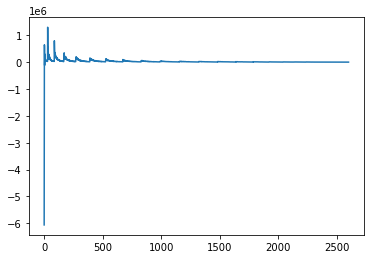

In [191]:
plt.plot(bk[:,2])

# CAMB data generation

In [2]:
camb = CAMB()

In [5]:
list_H0 = np.linspace(67.77-2.5,67.77+2.5,11)
list_Om = np.linspace(0.307-0.03,0.307+0.03,11)
list_z = [0.5]

In [6]:
list_H0, list_Om

(array([65.27, 65.77, 66.27, 66.77, 67.27, 67.77, 68.27, 68.77, 69.27,
        69.77, 70.27]),
 array([0.277, 0.283, 0.289, 0.295, 0.301, 0.307, 0.313, 0.319, 0.325,
        0.331, 0.337]))

In [2]:
# k = 0
# for h0 in list_H0:
#     for om in list_Om: 
#         ombh = 0.04825*(h0/100)**2
#         omch = (om-0.04825)*(h0/100)**2
#         results = camb.results(H0 = h0, ombh2 = ombh, omch2 = omch, omk = -0.0, all_z = list_z);
#         print(om,results.get_Omega("cdm")+results.get_Omega("baryon"),om+results.get_Omega("de"))
#         filename = f"camb_{int(np.round(h0,2)*100)}{int(om*10000)}_matterpower_z{''.join(map(str, list_z))}_{k:04}.dat"
#         parent_folder = "/home/jayashreeb/Documents/Power_Bi/nobao_project/data/camb_new/camb_python/"
#         infoname = f"infocamb_{int(np.round(h0,2)*100)}{int(om*10000)}_matterpower_z{''.join(map(str, list_z))}_{k:04}.npy"
#         info_folder = "/global/u1/s/shreeb/Project1/nobao_project/data/camb_new/camb_python_info/"
#         #np.save(info_folder + infoname, results.get_derived_params())
#         #print(filename, infoname)
#         kh,z,pkh = results.get_matter_power_spectrum(maxkh = 0.3/0.7, npoints = 200)
#         pk_kh = np.vstack((kh,pkh)).T
#         # np.savetxt(parent_folder + filename, pk_kh)
#         plt.plot(pk_kh[:,0],pk_kh[:,1])
#         #plt.legend()
#         k=k+1

# Model for bao : apply mcmc and curvefit

[13.23193237 12.25595536  9.80136397  7.71374685  6.04132948  5.11637458
  4.53120341  3.95196624  3.29563986  2.74828951  2.3689046   2.14634163
  1.9859681   1.80962756  1.61219936  1.43410921  1.29783012  1.20101217
  1.12553009  1.05182344  0.97635282  0.90374558  0.84083328  0.78948868
  0.74644159  0.70670753  0.66857676  0.63246127  0.59910273  0.56953518]
[ 8.2748755  13.01943376 11.40370297  8.66125774  6.76989471  5.78267872
  5.09782992  4.34617943  3.54381177  2.89850739  2.49522552  2.25616755
  2.04849291  1.81545963  1.5763781   1.37940146  1.23849274  1.13581866
  1.04556939  0.95390534  0.86460288  0.78637674  0.72206257  0.66879272
  0.62116893  0.5762354   0.53381187  0.49493449  0.46012228  0.42866972]


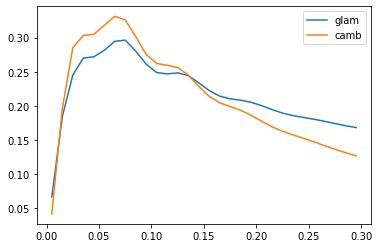

In [3]:

# Bk=np.load("../Molino_mocks/bk_molino_z0.npz")
# # Pk=np.load("../Molino_mocks/pk_molino_z0.npz")
# # k,pk0,pk2,pk4=Pk['k'], Pk['pk0'], Pk['pk2'], Pk['pk4']
# kk,bk0,bk2,bk4=Bk['kk'], Bk['bk0'], Bk['bk2'], Bk['bk4']
# # pkm=np.mean(pk0,axis=1)
# # bkm=np.mean(bk0,axis=1)

# Bk=np.load("data/glam/bk_z0.50.npz")
# Pk=np.load("data/glam/pk_z0.50.npz")
# k,pkm,pknm,pk,pkn=Pk['k'], Pk['pkm'].T[0],Pk['pknm'].T[0],Pk['pk'],Pk['pkn']
# kk,bkm,bknm,bk,bkn=Bk['k'], Bk['bkm'].T[0], Bk['bknm'].T[0],Bk['bk'],Bk['bkn']

# glamw = pkm/pknm
# print(pkm)
# plt.plot(k,k*pkm,label = "glam")

# # kk=kk[np.where((kk[:,0]!=kk[:,1]) & (kk[:,0]!=kk[:,2]))]
# # bkm=bkm[np.where((kk[:,0]!=kk[:,1]) & (kk[:,0]!=kk[:,2]))]
# # bk=bk[np.where((kk[:,0]!=kk[:,1]) & (kk[:,0]!=kk[:,2]))]
# # bknm=bknm[np.where((kk[:,0]!=kk[:,1]) & (kk[:,0]!=kk[:,2]))]
# # bkn=bkn[np.where((kk[:,0]!=kk[:,1]) & (kk[:,0]!=kk[:,2]))]
# # bk0=bk0[np.where((kk[:,0]!=kk[:,1]) & (kk[:,0]!=kk[:,2]))]


# #getting glam full_bispectrum data and it's covariance 
# # kg,bg,bgn,cov,scaled_cov,_ = cutslice(0.015,0.3,kk,bkm,bk,bknm,bk0)
# # icov = np.linalg.inv(cov)
# # print(cov.shape)

# def prepare_pk(use_glam = False):
#     if not use_glam:
#         pkcamb = np.loadtxt("data/camb/camb_25812257_matterpower_z0.dat")
#         _,pknmf,pkmf = less_baoPk(pkcamb,k,5)
#         pknmf = pknmf/np.mean(pknmf) * np.mean(pkm)
#         pkmf = pkmf/np.mean(pkmf) * np.mean(pknm)
#     else:
#         pkmf = pkm
#         pknmf = pknm
    
#     return pkmf,pknmf

# pkm,pknm = prepare_pk(use_glam = False)
# cambw = pkm/pknm
# print(pkm)
# plt.plot(k,k*pkm,label = "camb")
# plt.legend()
# def model(kk,*args):
#     alpha,f,b1,b2,A= args

#     #print(pkm,pknm)

#     pk1=np.interp(alpha*kk[:,0],k,pkm)
#     pk2=np.interp(alpha*kk[:,1],k,pkm)
#     pk3=np.interp(alpha*kk[:,2],k,pkm)

#     pkn1=np.interp(alpha*kk[:,0],k,pknm)
#     pkn2=np.interp(alpha*kk[:,1],k,pknm)
#     pkn3=np.interp(alpha*kk[:,2],k,pknm)

#     #res = Bi_meas(kk, pk1,pk2,pk3,pkn1,pkn2,pkn3,alpha,f,b1,b2, f1,b11,b21 )
#     bfa = np.array(Bi0(alpha*kk, pk1,pk2,pk3,f,b1,b2))
#     bsa = np.array(Bi0(alpha*kk, pkn1,pkn2,pkn3,f,b1,b2))
#     bs = np.array(Bi0(kk, pkn1,pkn2,pkn3,f,b1,b2))
#     #bw = np.array(Bi0(alpha*kk, pk1,pk2,pk3,f,b1,b2))/np.array(Bi0(alpha*kk, pkn1,pkn2,pkn3,f,b1,b2))

#     return bfa/bsa*bs

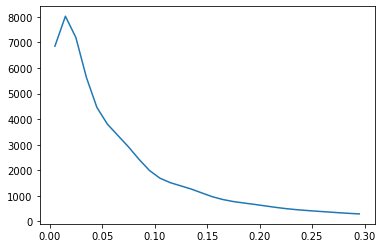

In [46]:
plt.plot(k,pkm)

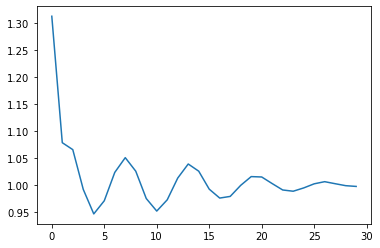

In [47]:
plt.plot(pkm/pknm)

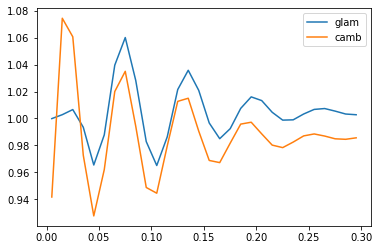

In [4]:
plt.plot(k[np.where(k>0.0)],glamw[np.where(k>0.0)],label = "glam")
plt.plot(k[np.where(k>0.0)],cambw[np.where(k>0.0)],label = "camb")
plt.legend()


In [24]:
k[np.where(glamw)]

array([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085,
       0.095, 0.105, 0.115, 0.125, 0.135, 0.145, 0.155, 0.165, 0.175,
       0.185, 0.195, 0.205, 0.215, 0.225, 0.235, 0.245, 0.255, 0.265,
       0.275, 0.285, 0.295])

In [25]:
# model = lambda kk,alpha,f,b1,b2,f1,b11,b21 : Bi_meas(kk, pk1,pk2,pk3,pkn1,pkn2,pkn3,alpha,f,b1,b2,f,b1,b2)
# model_wig = lambda kk,f,b1,b2 : Bi_wiggle(kk,pk1,pk2,pk3, pkn1,pkn2,pkn3, f, b1, b2)
# model_full=  lambda kk,alpha,f,b1,b2 : Bi0(alpha*kk,pk1,pk2,pk3 ,f, b1, b2)

In [31]:
k1,k2,k3=kg[:,0],kg[:,1],kg[:,2]
r=np.array(k1*k2*k3)**2
b0 = [1, 0.17356491,  1.91384586, -0.80008999,1]
bopt, bcov = curve_fit(model,kg,bgn,b0,maxfev=100000)

In [32]:
bopt

array([ 0.76984371,  0.0857446 ,  1.58744918, -0.55063981,  1.        ])

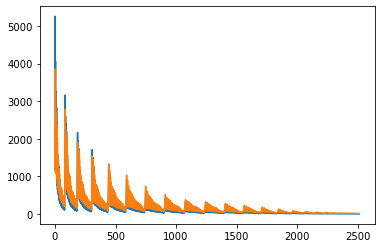

In [28]:
#bfg = 4.5*model(kg,1, 0.1, 1, -0.25,1)
plt.plot(model(kg,*bopt))
plt.plot(bg)
#plt.plot(bfg)


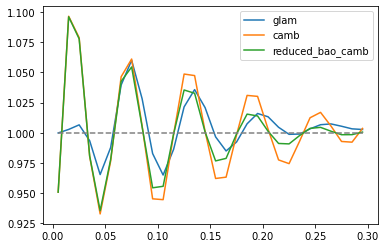

In [9]:
plt.plot(k,pkm/pknm, label = "glam")
plt.plot(k,fpk/ps, label = "camb")
plt.plot(k,less_baoPk(pcamb,k,4.5)/ps, label = "reduced_bao_camb")
plt.plot(k,[1]*len(k),"--",color = "gray")


plt.legend()

For kmax = 0.2, [ 1.        , -0.11796866,  1.94064156, -0.35380374]

For kmax = 0.3, [1.02921744, 1.05416385, 1.1561273 , 0.45504566]

In [ ]:
theow4 = model(kg,*bopt)
meas = bg/bgn
for i in tqdm(range(1)):
    plt.plot(np.abs(meas-theow4)/meas, ".", color = "green", label = "theo/meas;params=[0.149,1.911,-0.738")
    plt.ylabel("relative error")
    plt.legend()



# ABACUS smooth using curve-fit

In [28]:
import numpy as np
import argparse
import os, sys
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
from pathlib import Path
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)
from my_utils.mcmc.mcmc import RunMCMC
from my_utils.utils import *

import math
import warnings          # for ignoring the warnings (not recommended)
warnings.filterwarnings('ignore')

Bk_molino=np.load("../Molino_mocks/bk_molino_z0.npz")
bk_mol = Bk_molino["bk0"]

redshifts = ["BGS","ELG","LRG","QSO"]
i=0

Bk=np.load("data/Abacus/"+ redshifts[i] +"/bk_"+redshifts[i]+".npz")
Pk=np.load("data/Abacus/"+ redshifts[i] +"/pk_"+redshifts[i]+".npz")
k,pkm,pk=Pk['k'], Pk['pkm'],Pk['pk']
kk,bkm,bk=Bk['kk'], Bk['bkm'],Bk['bk']

kg,bg,bgn,cov,scaled_cov,_ = cutslice(0.015,0.3,kk,bkm,bk,bkm,bk,bk_mol)
icov = np.linalg.inv(scaled_cov)
# index = np.where(k>=0.015 and k<=0.2)
# k,pkm = k[index],pk[index]

def fit_smoothPk(Pkcamb,k):
    if len(Pkcamb.shape) == 2:
        Pcamb = Pkcamb[:,1]
        kcamb = Pkcamb[:,0]
    else:
        Pcamb = Pkcamb
        kcamb = k
    # kcamb[0]=0
    # Pcamb[0]=0
    fpk = np.interp(k,kcamb,Pcamb)
    Ps = lambda k,A0,keq,a0,a2,a4 : smoothPk(k,A0,keq,a0,a2,a4)
    p0 = [30000,0.05,0,0,0]
    popt, _ = curve_fit(Ps, k ,fpk, p0, (1/k)**2, maxfev=1000000)
    return fpk,smoothPk(k,*popt)

def model(kk,*args):
    f,b1,b2,S0,S1 = args

    fpkm,pknm = fit_smoothPk(pkm,k)

    pk1=np.interp(kk[:,0],k,pkm)
    pk2=np.interp(kk[:,1],k,pkm)
    pk3=np.interp(kk[:,2],k,pkm)

    pkn1=np.interp(kk[:,0],k,pknm)
    pkn2=np.interp(kk[:,1],k,pknm)
    pkn3=np.interp(kk[:,2],k,pknm)

    pkn11=np.interp(kk[:,0],k,pknm)
    pkn12=np.interp(kk[:,1],k,pknm)
    pkn13=np.interp(kk[:,2],k,pknm)

    res = Bi_wiggle(kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)*Bi0(kk,pkn11,pkn12,pkn13,f,b1,b2,S0,S1)
    return res

def get_smooth(kk,pk,*args):
    f,b1,b2,S0,S1 = args
    
    pk = pk/np.mean(pk)*np.mean(pkm)
    fpk,pkn = fit_smoothPk(pk,k)

    pk1=np.interp(kk[:,0],k,pk)
    pk2=np.interp(kk[:,1],k,pk)
    pk3=np.interp(kk[:,2],k,pk)

    pkn1=np.interp(kk[:,0],k,pkn)
    pkn2=np.interp(kk[:,1],k,pkn)
    pkn3=np.interp(kk[:,2],k,pkn)

    pkn11=np.interp(kk[:,0],k,pkn)
    pkn12=np.interp(kk[:,1],k,pkn)
    pkn13=np.interp(kk[:,2],k,pkn)
    
    bfull = np.array(Bi0(kk,pk1,pk2,pk3,f,b1,b2,S0,S1))
    bsmooth = np.array(Bi0(kk, pkn1,pkn2,pkn3,f,b1,b2,S0,S1))
    bwiggle = Bi_wiggle(kk,pk1,pk2,pk3,pkn1,pkn2,pkn3,f,b1,b2,S0,S1)
    
    return pk,fpk,pkn,bfull,bsmooth,bwiggle

def get_smooth_all(kk,pk,*args,filepath = "data/Abacus_mocks/", outpath = "data/Abacus/Abacus_smooth/"):
    all_pk = []
    all_bk = []
    N=0
    for file in os.listdir(filepath):
        if redshifts[i] in file and file[:2] == "pk" :
            file_pk = "pk"+file[2:]
            file_bk = "bk"+file[2:]
            pk = np.loadtxt(filepath+file_pk)[:,1]
            bk = np.loadtxt(filepath+file_bk)[:,3]
            
            pkfull,fpk,pksmooth,bfull,bsmooth,bwiggle = get_smooth(kk,pk,*args)
            all_pk = np.stack((k,pk,pksmooth)).T
            all_bk = np.stack((kk[:,0],kk[:,1],kk[:,2],bk,bfull,bsmooth)).T
            print(file_pk,file_bk,all_pk.shape,all_bk.shape)
            np.savetxt(outpath+"all_"+file_pk,all_pk)
            np.savetxt(outpath+"all_"+file_bk,all_bk)
            N=N+1
            # break
    print(N)
    # return all_pk, all_bk
            

kmax=0.3, kmin=0.015, nbins=2513, nmocks=25, hf = -0.00963855421686747


In [29]:
k1,k2,k3=kg[:,0],kg[:,1],kg[:,2]
r=np.array(k1*k2*k3)**2
b0 = [1,1,1,1,1]
bopt, bcov = curve_fit(model,kg,bgn,b0,1/r,maxfev=100000)
print(bopt)

KeyboardInterrupt: 

In [ ]:
# bopt = [-3.33487041e-02 ,5.86745432e-01 ,-7.45187795e-02 , 6.25950689e+04, 1.02927432e-01] #ELGs
# bopt = [ 6.39831982e-03 , 1.05501348e+00 , 1.49932843e+00 , 8.72775638e+02, -1.53462242e+01] #LRGs
plt.plot(bgn)
plt.plot(model(kg,*bopt))

In [ ]:
pkf,fpk,pkn,bfull,bsmooth,bwiggle = get_smooth(kk,pkm,*bopt)

In [ ]:
plt.plot(bkm/bsmooth,label = "true full / best-fit smooth")
plt.plot(bfull/bsmooth,label = "best-fit full / best-fit smooth")

plt.legend()
# plt.plot(bwiggle)
plt.ylim(0,2)

In [27]:
get_smooth_all(kk,pk,*bopt)

pk_QSOz2_5018.txt bk_QSOz2_5018.txt (30, 3) (2600, 6)
pk_QSOz2_5010.txt bk_QSOz2_5010.txt (30, 3) (2600, 6)
pk_QSOz2_5011.txt bk_QSOz2_5011.txt (30, 3) (2600, 6)
pk_QSOz2_5004.txt bk_QSOz2_5004.txt (30, 3) (2600, 6)
pk_QSOz2_5012.txt bk_QSOz2_5012.txt (30, 3) (2600, 6)
pk_QSOz2_5001.txt bk_QSOz2_5001.txt (30, 3) (2600, 6)
pk_QSOz2_5019.txt bk_QSOz2_5019.txt (30, 3) (2600, 6)
pk_QSOz2_5008.txt bk_QSOz2_5008.txt (30, 3) (2600, 6)
pk_QSOz2_5017.txt bk_QSOz2_5017.txt (30, 3) (2600, 6)
pk_QSOz2_5022.txt bk_QSOz2_5022.txt (30, 3) (2600, 6)
pk_QSOz2_5013.txt bk_QSOz2_5013.txt (30, 3) (2600, 6)
pk_QSOz2_5014.txt bk_QSOz2_5014.txt (30, 3) (2600, 6)
pk_QSOz2_5024.txt bk_QSOz2_5024.txt (30, 3) (2600, 6)
pk_QSOz2_5023.txt bk_QSOz2_5023.txt (30, 3) (2600, 6)
pk_QSOz2_5007.txt bk_QSOz2_5007.txt (30, 3) (2600, 6)
pk_QSOz2_5000.txt bk_QSOz2_5000.txt (30, 3) (2600, 6)
pk_QSOz2_5020.txt bk_QSOz2_5020.txt (30, 3) (2600, 6)
pk_QSOz2_5015.txt bk_QSOz2_5015.txt (30, 3) (2600, 6)
pk_QSOz2_5005.txt bk_QSOz2_5

In [25]:
pkf,fpk,pkn,bfull,bsmooth,bwiggle = get_smooth(kk,pk[:,1],*bopt)

(0.0, 2.0)

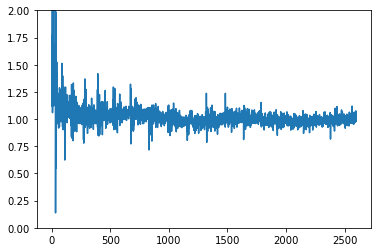

In [26]:
plt.plot(bk[:,0]/bsmooth)
# plt.plot(pkf/pkn)
plt.ylim(0,2)

# Get best fit values from a mcmc chain

In [3]:
import emcee
import corner
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
import getdist
import IPython
import numpy as np
import os
from pathlib import Path
from astropy.cosmology import FlatLambdaCDM

%matplotlib inline

In [230]:


# reader = emcee.backends.HDFBackend("/global/homes/s/shreeb/Project1/nobao_project/mcmc_results/mcmc_camb_64001419_matterpower_z0.5_0009.h5",read_only=True)
# flat_samples = reader.get_chain(discard=300, thin=15, flat=True)
# alpha_mo = np.mean(flat_samples[:,0])

In [30]:
info_path = "/global/homes/s/shreeb/Project1/nobao_project/data/camb_new/camb_python_info/"
mcmc_path = "/global/homes/s/shreeb/Project1/nobao_project/beocat_mcmc_results/mcmc_results_new/"

z = 0.5
cglam = FlatLambdaCDM(H0=67.77, Om0=0.307)
dglam = cglam.comoving_distance(z)
rsglam = 147.82

all_H0 = []
all_Om0 = []
all_errors = []

# list_H0 = np.linspace(64,72,10)
# list_omch2 = np.linspace(0.112,0.142,10)

list_H0 = np.linspace(67.77-2.5,67.77+2.5,11)
list_Om = np.linspace(0.307-0.03,0.307+0.03,11)
X, Y = np.meshgrid(list_H0, list_Om)

Z = np.zeros((11,11))

for i in range(11):
    for j in range(11):
        h0 = list_H0[i]
        om=list_Om[j]
        ombh = 0.04825*(h0/100)**2
        omch = (om-0.04825)*(h0/100)**2
        match = f"{int(h0*100)}{int(om*10000)}" 
        #print(h0, om, omch)
        for file in os.listdir(mcmc_path):
            name = Path(file).stem
            index = name[10:18]
            if index != "ints":
                if index == match:
                    #print(index,match)
                    info_name = "info"+name[5:]+".npy"
                    info = np.load(info_path + info_name, allow_pickle = True)
                    rscamb = info.item()['rdrag']
                    # H0 = int(name[10:12])+int(name[12:14])/100
                    # omch2 = int(name[14:18])/10000
                    # ombh2 = 0.04825*(H0/100)**2
                    # Om0 = (ombh2+omch2)/((H0/100)**2)
                    #print(H0,omch2,Om0)
                    ccamb = FlatLambdaCDM(H0=h0, Om0=om)
                    dcamb = ccamb.comoving_distance(z)

                    #print(dcamb)
                    alpha_true = (dcamb/rscamb)/(dglam/rsglam)


                    reader = emcee.backends.HDFBackend(mcmc_path + file,read_only=True)
                    flat_samples = reader.get_chain(discard=500, thin=15, flat=True)
                    alpha_model = np.mean(flat_samples[:,0])

                    error = (np.abs(alpha_true-alpha_model)/alpha_true)*100

                    all_H0.append(h0)
                    all_Om0.append(om)
                    all_errors.append(error)
                    Z[i,j]=error
                    #print(H0,Om0,error)

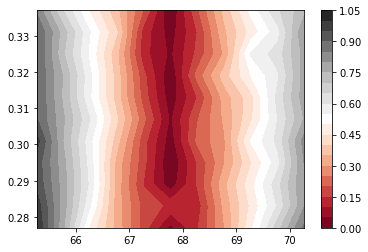

In [31]:
plt.contourf(X, Y, Z, 20, cmap='RdGy')
plt.colorbar();


In [32]:
# info_path = "/global/homes/s/shreeb/Project1/nobao_project/data/camb_python_info/"
# mcmc_path = "/global/homes/s/shreeb/Project1/nobao_project/beocat_mcmc_results/mcmc_results/"

# z = 0.5
# cglam = FlatLambdaCDM(H0=67.77, Om0=0.307)
# dglam = cglam.comoving_distance(z)
# rsglam = 147.82
# #ind = np.arange(0,66)

# all_H0 = []
# all_Om0 = []
# all_errors = []

# list_H0 = np.linspace(64,72,10)
# list_omch2 = np.linspace(0.112,0.142,10)

# for file in os.listdir(mcmc_path):
#     name = Path(file).stem
#     index = name[-4:]
#     if index != "ints":
#         if int(index) == ind:
#             print(file)
#             info_name = "info"+name[5:]+".npy"
#             info = np.load(info_path + info_name, allow_pickle = True)
#             rscamb = info.item()['rdrag']
#             H0 = int(name[10:12])+int(name[12:14])/100
#             omch2 = int(name[14:18])/10000
#             ombh2 = 0.04825*(H0/100)**2
#             Om0 = (ombh2+omch2)/((H0/100)**2)
#             #print(H0,omch2,Om0)
#             ccamb = FlatLambdaCDM(H0=H0, Om0=Om0)
#             dcamb = ccamb.comoving_distance(z)
            
#             #print(dcamb)
#             alpha_true = (dcamb/rscamb)/(dglam/rsglam)
            
            
#             reader = emcee.backends.HDFBackend(mcmc_path + file,read_only=True)
#             flat_samples = reader.get_chain(discard=300, thin=15, flat=True)
#             alpha_model = np.mean(flat_samples[:,0])
            
#             error = (np.abs(alpha_true-alpha_model)/alpha_true)*100
            
#             all_H0.append(H0)
#             all_Om0.append(Om0)
#             all_errors.append(error)
#             #print(H0,Om0,error)
        

Text(0, 0.5, 'Omega_m')

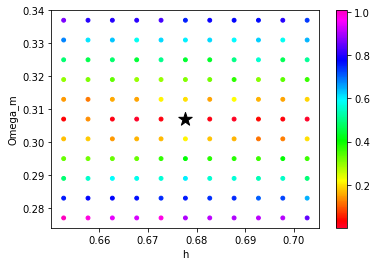

In [34]:
plt.scatter(np.array(all_H0)/100, all_Om0, s = 15, c = all_errors,cmap = "gist_rainbow")
plt.colorbar()
plt.scatter(0.6777,0.307, s = 200 , c= "black", marker = "*")
plt.xlabel("h")
plt.ylabel("Omega_m")


TypeError: Input z must be 2D, not 1D

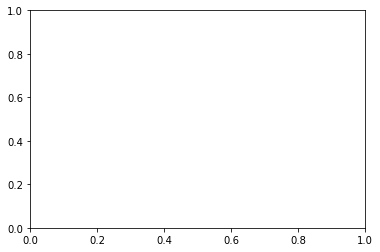

In [118]:
fig, ax = plt.subplots()
CS = ax.contour(np.array(all_H0)/100, all_Om0, all_errors)
ax.clabel(CS, inline=True, fontsize=10)
ax.set_title('Simplest default with labels')

In [106]:
(0.307 - 0.04825)*0.6777**2

0.11883799878749998

In [110]:
min(all_Om0)

0.112

# Get true alpha and compare to best fit alpha : using ASTROPY

In [10]:
from astropy.cosmology import FlatLambdaCDM
z = 0.5
H0 = 70
Om0 = 0.287306
ccamb = FlatLambdaCDM(H0=H0, Om0= Om0)
cglam = FlatLambdaCDM(H0=67.77, Om0=0.307)

rsglam = 147.82
rscamb = 147.50

In [11]:
dcamb = ccamb.comoving_distance(z)
dglam = cglam.comoving_distance(z)

In [12]:
dcamb

<Quantity 1897.00982543 Mpc>

In [20]:
alpha = (dcamb/rscamb)/(dglam/rsglam)

In [21]:
alpha

<Quantity 0.97690945>

In [38]:
(alpha-0.978)/alpha *100

<Quantity 0.36592418>

In [2]:
# from pathlib import Path
# filepaths="data/camb"
# for file in os.listdir(filepaths):
#     if file[-3:] == "dat":
#         filepath = filepaths +"/" + file
#         output_path = "/home/jayashreeb/Documents/Power_Bi/nobao_project/mcmc_parallel_results/mcmc_" + Path(filepath).stem + ".h5"
#         print(filepath,"\n",output_path)

# Get required plots for draft

### Power Spectrum

- ##### Mean pure BAO vs the best-fit model for GLAM power at different redshifts with : 
        - Same cosmology
        - Wrong cosmology corrected by alpha

In [ ]:
path = " /global/u1/l/lado/GLAM_Bi"

### Bispectrum

- ##### Mean pure BAO vs the best-fit model for GLAM power at  different redshifts with :
        - Same cosmology
        - Wrong cosmology corrected by alpha

- ##### MCMC chains showing consistency of alpha at z = 0.5 and z = 0.0.
- ##### 2 mcmc plots with and without gaussian parameter, sigma.
- ##### One plot showing imposing priors doesn't make a difference
- ##### Systematic offset in omegam (fixed omegab) vs H0 plane.


